In [1]:
import os
import zipfile
import requests
import glob
import sys
import re
import time

import warnings
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from PIL import Image

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobile_preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import decode_predictions as mobile_decode_predictions
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import decode_predictions as inception_decode_predictions

from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras import regularizers


%matplotlib inline

2025-01-04 19:21:43.741483: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736036503.936831  758207 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736036509.263284  758207 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-04 19:21:43.722890: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Getting python version
print(sys.version)

3.12.3 (main, Nov  6 2024, 18:32:19) [GCC 13.2.0]


In [3]:
#Getting tensorflow version
tf.__version__

'2.18.0'

In [4]:
#Checking that Tensorflow detects a GPU
gpus = tf.config.list_physical_devices('GPU')
print("GPUs Available:", gpus)

GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
if gpus:
    try:
        # Restrict TensorFlow to only allocate memory as needed
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [6]:
# Check if the TF_GPU_ALLOCATOR environment variable is set
gpu_allocator = os.environ.get('TF_GPU_ALLOCATOR')

if gpu_allocator is None:
    print("Warning: The TF_GPU_ALLOCATOR environment variable is not set. This variable determines how TensorFlow manages GPU memory allocation."
          "Setting it to 'cuda_malloc_async' can improve performance on NVIDIA GPUs by reducing memory fragmentation during model training. "
          " Please consider setting the variable before running the model (export TF_GPU_ALLOCATOR=cuda_malloc_async)")
else:
    print(f"TF_GPU_ALLOCATOR is set to: {gpu_allocator}")

TF_GPU_ALLOCATOR is set to: cuda_malloc_async


In [7]:
#set mixed precision policy
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [8]:
#setting seeds
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [9]:
#hide some warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [10]:
# Start timer to measure execution time
start_time = time.time()

# Download images to train our model

In [11]:
DATASET_DIR = '../dataset/fashion-product-images-small/'
ZIP_FILE_PATH = os.path.join(DATASET_DIR, 'fashion-product-images-small.zip')
DOWNLOAD_URL = 'https://www.kaggle.com/api/v1/datasets/download/paramaggarwal/fashion-product-images-small'

In [12]:
def is_empty_directory(directory):
    return not os.listdir(directory)

In [13]:
if is_empty_directory(DATASET_DIR):
    print("Empty dataset directory. Downloading ZIP File from Kaggle...")
    
    response = requests.get(DOWNLOAD_URL, allow_redirects=True)
    with open(ZIP_FILE_PATH, 'wb') as file:
        file.write(response.content)
    print("Download completed.")

    # Extract the ZIP file
    with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
        zip_ref.extractall(DATASET_DIR)
    print("ZIP file extracted.")

    # Delete the ZIP file after extraction
    os.remove(ZIP_FILE_PATH)
else:
    print("The are images already downloaded. No need to download Zip file from Kaggle")

The are images already downloaded. No need to download Zip file from Kaggle


# EDA

In [14]:
#Load an image
image_path = f'{DATASET_DIR}/images/'
fullname = f'{image_path}/10009.jpg'
img=load_img(fullname, target_size=(224,224))

In [15]:
x=np.array(img)
x.shape

(224, 224, 3)

In [16]:
## Reading informacion about images
CSV_FILE_PATH = F'{DATASET_DIR}/styles.csv'

In [17]:
# Read the first few rows of the CSV to inspect its structure
preview_data = pd.read_csv(CSV_FILE_PATH, nrows=5)
print(preview_data.head())

      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

   year   usage                             productDisplayName  
0  2011  Casual               Turtle Check Men Navy Blue Shirt  
1  2012  Casual             Peter England Men Party Blue Jeans  
2  2016  Casual                       Titan Women Silver Watch  
3  2011  Casual  Manchester United Men Solid Black Track Pants  
4  2012  Casual                          Puma Men Grey T-shirt  


In [18]:
#read dataset and skip some bad lines
columns=['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'productDisplayName']
data = pd.read_csv(CSV_FILE_PATH,  usecols=columns, on_bad_lines='skip')
data.head()

,id,gender,masterCategory,subCategory,articleType,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Puma Men Grey T-shirt


In [19]:
#Adding a new column to dataset, with the file name
data['filename'] = data['id'].astype(str)+'.jpg'
data['filename'] = data['filename'].str.strip() 
data['filename'] = data['filename'].str.lower()  
data.head()

,id,gender,masterCategory,subCategory,articleType,productDisplayName,filename
0,15970,Men,Apparel,Topwear,Shirts,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Puma Men Grey T-shirt,53759.jpg


In [20]:
IMAGES_DIR = f'{DATASET_DIR}/images'

In [21]:
# Checking for invalid filenames and getting information about images
invalid_filenames = []
image_sizes = []
all_images = []
for filename in data['filename']:
    file_path = os.path.join(IMAGES_DIR, filename)
    if not os.path.exists(file_path):
        invalid_filenames.append(filename)
    else:
        img = Image.open(file_path)
        image_sizes.append(img.size)
print("Invalid filenames:\n")
for invalid in invalid_filenames:
    print(invalid)


Invalid filenames:

39403.jpg
39410.jpg
39401.jpg
39425.jpg
12347.jpg


In [22]:
# Checking for images which information might not be on the dataset 
all_images = set(os.listdir(IMAGES_DIR))
dataset_filenames = set(data['filename'])
orphaned_images = all_images-dataset_filenames
if orphaned_images:
    print("\nOrphaned images (not in the dataset):\n")
    for img in orphaned_images:
        print(img)
else:
    print("\nAll images in the directory have corresponding entries in the dataset.")


All images in the directory have corresponding entries in the dataset.


In [23]:
#There are some missing images, we will just erase their information from the dataset
data_cleaned = data[~data['filename'].isin(invalid_filenames)]
print(f'Total images that will be used as input: {len(data_cleaned)}')

Total images that will be used as input: 44441


Displaying image corresponding to the article 'Turtle Check Men Navy Blue Shirt' of type 'Shirts'


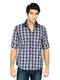

In [24]:
#Load one of the images to check is dimensions
sample_image_filename = data.iloc[0].filename
sample_image_fullname = f'{IMAGES_DIR}/{sample_image_filename}'
sample_image_displayName =  data.iloc[0].productDisplayName
sample_image_articleType = data.iloc[0].articleType
img = load_img(sample_image_fullname)

print(f'Displaying image corresponding to the article \'{sample_image_displayName}\' of type \'{sample_image_articleType}\'')
img

In [25]:
x=np.array(img)
x.shape

(80, 60, 3)

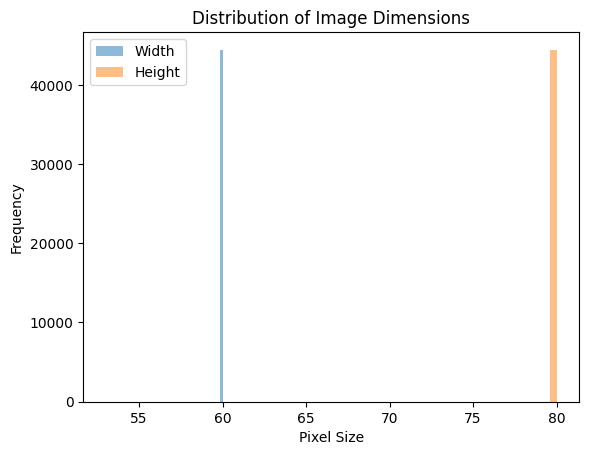

In [26]:
#Analyzing distribution of image dimensions
width, height = zip(*image_sizes)
plt.hist(width, bins=50, alpha=0.5, label='Width')
plt.hist(height, bins=50, alpha=0.5, label='Height')
plt.xlabel('Pixel Size')
plt.ylabel('Frequency')
plt.title('Distribution of Image Dimensions')
plt.legend()
plt.show()

In [27]:
# Conclusion: All the images have a size of 60x80

In [28]:
#Analyzing how many articles are there per class
sub_category_counts =data.groupby('articleType').size().reset_index(name='count')
sub_category_counts.sort_values(by='count', ascending=True)

,articleType,count
10,Body Wash and Scrub,1
26,Cushion Covers,1
54,Ipad,1
46,Hair Accessory,1
106,Shoe Laces,1
...,...,...
112,Sports Shoes,2036
140,Watches,2542
19,Casual Shoes,2846
104,Shirts,3217


In [29]:
# Conclusion: There are some categories for which we have very few samples

In [30]:
# Filter the article types to keep only those with more than 4 samples 
#(we need at least 1 sample in each dataframe: train, val and test and with a small quantity of samples, it is difficult to achieve)
valid_article_types = sub_category_counts[sub_category_counts['count'] >= 4]['articleType']
data_cleaned = data_cleaned[data_cleaned['articleType'].isin(valid_article_types)]

In [31]:
count_classes_in_dataframe = data_cleaned['articleType'].nunique()
count_classes_in_dataframe

128

In [32]:
#split the data into training, validation and test datasets
full_train_df, test_df = train_test_split(data_cleaned, test_size=0.2, random_state=42, stratify=data_cleaned['articleType'])
train_df, val_df = train_test_split(full_train_df, test_size=0.25, random_state=42, stratify=full_train_df['articleType'])

In [33]:
# Summary of the splits
print("Training Data Shape:", train_df.shape)
print("Validation Data Shape:", val_df.shape)
print("Test Data Shape:", test_df.shape)

Training Data Shape: (26649, 7)
Validation Data Shape: (8883, 7)
Test Data Shape: (8883, 7)


In [34]:
print("Unique classes in training dataset:")
print(train_df['articleType'].value_counts())

print("\nUnique classes in validation dataset:")
print(val_df['articleType'].value_counts())

print("\nUnique classes in test dataset:")
print(test_df['articleType'].value_counts())


Unique classes in training dataset:
articleType
Tshirts             4241
Shirts              1929
Casual Shoes        1708
Watches             1525
Sports Shoes        1222
                    ... 
Beauty Accessory       2
Makeup Remover         2
Lip Plumper            2
Robe                   2
Lehenga Choli          2
Name: count, Length: 128, dtype: int64

Unique classes in validation dataset:
articleType
Tshirts            1414
Shirts              643
Casual Shoes        569
Watches             508
Sports Shoes        407
                   ... 
Lehenga Choli         1
Eye Cream             1
Nail Essentials       1
Umbrellas             1
Nehru Jackets         1
Name: count, Length: 128, dtype: int64

Unique classes in test dataset:
articleType
Tshirts             1414
Shirts               643
Casual Shoes         569
Watches              509
Sports Shoes         407
                    ... 
Wristbands             1
Headband               1
Lehenga Choli          1
Beauty Accesso

# Transfering learning

## Preparing input for Model v1 with MobileNetV2

In [57]:
# defining a target size for images
TARGET_SIZE = (112, 112)
#defining a batch size
BATCH_SIZE=32
#defining a max queue size (count of batches preloaded in the queue while the model is training)
MAX_QUEUE_SIZE=10

In [58]:
# calculating how many workers threads for loading data
##warning: it is not certain that these parameters are being used by the ImageDataGenerator
num_cores = os.cpu_count()
workers = int(num_cores / 2)
use_multiprocessing=False
if workers>1:
   use_multiprocessing=True

In [59]:
#Read images by using ImageDataGenerator (we will use the articleType as our class)
train_image_gen = ImageDataGenerator(preprocessing_function=mobile_preprocess_input)
train_gen = train_image_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGES_DIR, 
    x_col='filename',  
    y_col='articleType', 
    target_size=TARGET_SIZE, 
    batch_size=BATCH_SIZE,
    class_mode='categorical',  
    workers = workers,
    use_multiprocessing=use_multiprocessing,
    max_queue_size=MAX_QUEUE_SIZE
)

Found 26649 validated image filenames belonging to 128 classes.


In [60]:
val_image_gen = ImageDataGenerator(preprocessing_function=mobile_preprocess_input)
val_gen = val_image_gen.flow_from_dataframe(
    dataframe=val_df,
    directory=IMAGES_DIR, 
    x_col='filename',  
    y_col='articleType', 
    target_size=TARGET_SIZE, 
    batch_size=BATCH_SIZE,
    class_mode='categorical',  
    shuffle=False,
    workers = workers,
    use_multiprocessing=use_multiprocessing,
    max_queue_size=MAX_QUEUE_SIZE    
)

Found 8883 validated image filenames belonging to 128 classes.


In [61]:
generated_classes = list(train_gen.class_indices.keys())
classes_in_dataframe = list(train_gen.class_indices.keys())
if set(classes_in_dataframe) == set(generated_classes):
    print("\nThe classes in train_df match the classes in the ImageDataGenerator.")
else:
    print("\nThere is a mismatch between the classes!")
    print("Classes in train_df:", classes_in_dataframe)
    print("Classes from ImageDataGenerator:", generated_classes)


The classes in train_df match the classes in the ImageDataGenerator.


In [62]:
class_indices = train_gen.class_indices
class_indices

{'Accessory Gift Set': 0,
 'Baby Dolls': 1,
 'Backpacks': 2,
 'Bangle': 3,
 'Basketballs': 4,
 'Bath Robe': 5,
 'Beauty Accessory': 6,
 'Belts': 7,
 'Blazers': 8,
 'Body Lotion': 9,
 'Booties': 10,
 'Boxers': 11,
 'Bra': 12,
 'Bracelet': 13,
 'Briefs': 14,
 'Camisoles': 15,
 'Capris': 16,
 'Caps': 17,
 'Casual Shoes': 18,
 'Churidar': 19,
 'Clothing Set': 20,
 'Clutches': 21,
 'Compact': 22,
 'Concealer': 23,
 'Cufflinks': 24,
 'Deodorant': 25,
 'Dresses': 26,
 'Duffel Bag': 27,
 'Dupatta': 28,
 'Earrings': 29,
 'Eye Cream': 30,
 'Eyeshadow': 31,
 'Face Moisturisers': 32,
 'Face Scrub and Exfoliator': 33,
 'Face Wash and Cleanser': 34,
 'Flats': 35,
 'Flip Flops': 36,
 'Footballs': 37,
 'Formal Shoes': 38,
 'Foundation and Primer': 39,
 'Fragrance Gift Set': 40,
 'Free Gifts': 41,
 'Gloves': 42,
 'Hair Colour': 43,
 'Handbags': 44,
 'Headband': 45,
 'Heels': 46,
 'Highlighter and Blush': 47,
 'Innerwear Vests': 48,
 'Jackets': 49,
 'Jeans': 50,
 'Jeggings': 51,
 'Jewellery Set': 52,
 '

In [41]:
count_classes = len(class_indices)
print (f'Category count:  {count_classes}')

Category count:  128


In [42]:
#Checking size of images and batches

train_batch_images_train, train_batch_labels = next(train_gen)  
if train_batch_labels.shape[1] == count_classes_in_dataframe:
    print("Training labels match the expected number of classes: OK")
else:
    print(f"Error: Training labels do not match the expected number of classes! Expected {count_classes_in_dataframe}, got {train_batch_labels.shape[1]}.")
print("Batch shape for training:", train_batch_images_train.shape) 


val_batch_images, val_batch_labels = next(val_gen)  
if val_batch_labels.shape[1] == count_classes_in_dataframe:
    print("Validation labels match the expected number of classes: OK")
else:
    print(f"Error: Validation labels do not match the expected number of classes! Expected {count_classes_in_dataframe}, got {val_batch_labels.shape[1]}.")
print("Batch shape for validation:", val_batch_images.shape) 


Training labels match the expected number of classes: OK
Batch shape for training: (32, 96, 96, 3)
Validation labels match the expected number of classes: OK
Batch shape for validation: (32, 96, 96, 3)


In [43]:
# Initialize a dictionary to store results for each model
model_results = {}

## Create Model v1 with MobileNetV2

In [44]:
def make_model_Mobile_v1(learning_rate=0.01):
    #clear any unused session
    tf.keras.backend.clear_session()

    #creating a base model
    input_shape = (TARGET_SIZE[0], TARGET_SIZE[1], 3)
    base_model =MobileNetV2(weights='imagenet', input_shape=input_shape, include_top=False)
    # create a model from the base model
    base_model.trainable=False
    inputs = keras.Input(shape=input_shape)
    base = base_model(inputs, training=False)
    
    #pooling layer
    pooling = keras.layers.GlobalAveragePooling2D()
    vectors = pooling(base)
    
    #dense layer
    outputs = keras.layers.Dense(count_classes, activation='softmax')(vectors)

    #final model
    model = keras.Model(inputs, outputs)

    #compile de model
    optimizer =keras.optimizers.Adam(learning_rate=learning_rate)
    loss=keras.losses.CategoricalCrossentropy(from_logits=False)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

In [46]:
model = make_model_Mobile_v1()
history=model.fit(train_gen, epochs=10, validation_data=val_gen)

I0000 00:00:1735616357.766314  104579 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1735616357.770950  104579 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2245 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Epoch 1/10


I0000 00:00:1735616362.070171  131429 service.cc:148] XLA service 0x7fe2140419e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735616362.070212  131429 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2024-12-30 22:39:22.167174: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735616362.689986  131429 cuda_dnn.cc:529] Loaded cuDNN version 90600
2024-12-30 22:39:30.740497: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng34{k2=2,k4=1,k5=0,k6=0,k7=0,k19=0} for conv (f32[32,32,12,12]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,192,12,12]{3,2,1,0}, f32[32,192,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result

 12/833 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.2968 - loss: 5.0276      

I0000 00:00:1735616365.551847  131429 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


257/833 ━━━━━━━━━━━━━━━━━━━━ 23s 40ms/step - accuracy: 0.6008 - loss: 2.8456

2024-12-30 22:39:40.747919: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{} for conv (f32[25,32,48,48]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,32,48,48]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=32, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2024-12-30 22:39:40.776114: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 6.808907286s
Trying algorithm eng4{} for conv (f32[25,32,48,48]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,32,48,48]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=32, custom_call_target="__cudnn$convForward", backend_config={"cudnn_co

833/833 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.6673 - loss: 2.4851 - val_accuracy: 0.7544 - val_loss: 2.1165
Epoch 2/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.8137 - loss: 1.2700 - val_accuracy: 0.7761 - val_loss: 2.2099
Epoch 3/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.8502 - loss: 1.0521 - val_accuracy: 0.7810 - val_loss: 2.4770
Epoch 4/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.8738 - loss: 0.8627 - val_accuracy: 0.7977 - val_loss: 2.6275
Epoch 5/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.8848 - loss: 0.7810 - val_accuracy: 0.7905 - val_loss: 3.0652
Epoch 6/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.8984 - loss: 0.6921 - val_accuracy: 0.7934 - val_loss: 3.0898
Epoch 7/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.9030 - loss: 0.6619 - val_accuracy: 0.7674 - val_loss: 3.6354
Epoch 8/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.9073 - loss: 0.6561 - val_accurac

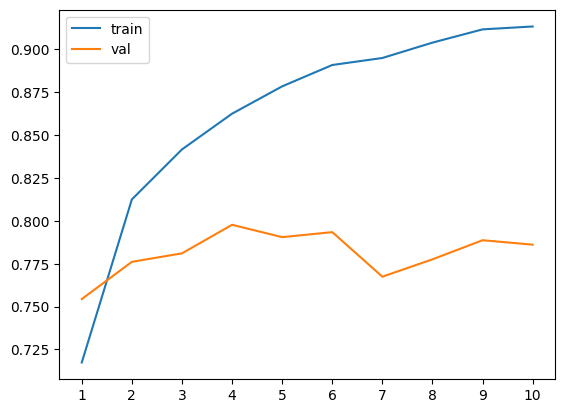

In [47]:
#Plotting train and validation accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10), np.arange(1,11))
plt.legend()

In [48]:
## Conclusion: the model overfits the training data. Accuracy for validation dataset does not surpasses 80%

## Create Model v1 with InceptionV3

## Preparing input for Model v1 with InceptionV3

In [49]:
#Read images by using ImageDataGenerator (we will use the articleType as our class)
train_image_gen = ImageDataGenerator(preprocessing_function=inception_preprocess_input)
train_gen = train_image_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGES_DIR, 
    x_col='filename',  
    y_col='articleType', 
    target_size=TARGET_SIZE, 
    batch_size=BATCH_SIZE,
    class_mode='categorical',  
    workers = workers,
    use_multiprocessing=use_multiprocessing,
    max_queue_size=MAX_QUEUE_SIZE
)

Found 26649 validated image filenames belonging to 128 classes.


In [50]:
val_image_gen = ImageDataGenerator(preprocessing_function=inception_preprocess_input)
val_gen = val_image_gen.flow_from_dataframe(
    dataframe=val_df,
    directory=IMAGES_DIR, 
    x_col='filename',  
    y_col='articleType', 
    target_size=TARGET_SIZE, 
    batch_size=BATCH_SIZE,
    class_mode='categorical',  
    shuffle=False,
    workers = workers,
    use_multiprocessing=use_multiprocessing,
    max_queue_size=MAX_QUEUE_SIZE    
)

Found 8883 validated image filenames belonging to 128 classes.


In [51]:
def make_model_Inception_v1(learning_rate=0.01):
    #clear any unused session
    tf.keras.backend.clear_session()

    #creating a base model
    input_shape = (TARGET_SIZE[0], TARGET_SIZE[1], 3)
    base_model =InceptionV3(weights='imagenet', input_shape=input_shape, include_top=False)
    # create a model from the base model
    base_model.trainable=False
    inputs = keras.Input(shape=input_shape)
    base = base_model(inputs, training=False)
    
    #pooling layer
    pooling = keras.layers.GlobalAveragePooling2D()
    vectors = pooling(base)
    
    #dense layer
    outputs = keras.layers.Dense(count_classes, activation='softmax')(vectors)

    #final model
    model = keras.Model(inputs, outputs)

    #compile de model
    optimizer =keras.optimizers.Adam(learning_rate=learning_rate)
    loss=keras.losses.CategoricalCrossentropy(from_logits=False)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

In [52]:
model = make_model_Inception_v1()
history=model.fit(train_gen, epochs=10, validation_data=val_gen)

Epoch 1/10
801/833 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5277 - loss: 5.2213 

2024-12-30 22:43:06.025243: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng42{k2=1,k4=1,k5=1,k6=0,k7=0} for conv (f32[19,192,4,4]{3,2,1,0}, u8[0]{0}) custom-call(f32[19,768,4,4]{3,2,1,0}, f32[192,768,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2024-12-30 22:43:06.028609: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 6.671418877s
Trying algorithm eng42{k2=1,k4=1,k5=1,k6=0,k7=0} for conv (f32[19,192,4,4]{3,2,1,0}, u8[0]{0}) custom-call(f32[19,768,4,4]{3,2,1,0}, f32[192,768,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{

833/833 ━━━━━━━━━━━━━━━━━━━━ 52s 49ms/step - accuracy: 0.5300 - loss: 5.2117 - val_accuracy: 0.6601 - val_loss: 4.9024
Epoch 2/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - accuracy: 0.7067 - loss: 3.2826 - val_accuracy: 0.6686 - val_loss: 5.0049
Epoch 3/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - accuracy: 0.7423 - loss: 2.8127 - val_accuracy: 0.6840 - val_loss: 6.4371
Epoch 4/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - accuracy: 0.7680 - loss: 2.5376 - val_accuracy: 0.6831 - val_loss: 6.3555
Epoch 5/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - accuracy: 0.7938 - loss: 2.1285 - val_accuracy: 0.6838 - val_loss: 6.5699
Epoch 6/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - accuracy: 0.8114 - loss: 2.0002 - val_accuracy: 0.6921 - val_loss: 6.0946
Epoch 7/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.8215 - loss: 1.8587 - val_accuracy: 0.6977 - val_loss: 6.9588
Epoch 8/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - accuracy: 0.8395 - loss: 1.6840 - val_accurac

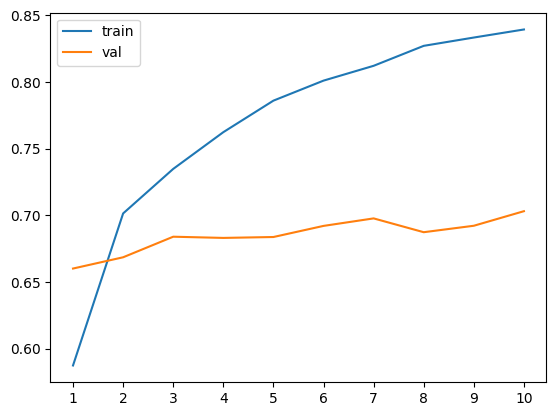

In [53]:
#Plotting train and validation accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10), np.arange(1,11))
plt.legend()

In [54]:
#Conclusion: the Mobile model performs better than the Inception model, and the latter one is slower
## so, the base layer of the model used in this project will be based on MobileNetV2

### Adjusting learning rate for Model version 1

In [55]:
scores={}
print("Training with different learning rates:\n")
for lr in [0.0001, 0.0005, 0.001, 0.01, 0.1]:
    print(lr)
    model = make_model_Mobile_v1(learning_rate=lr)
    history = model.fit(train_gen, epochs=10, validation_data=val_gen)
    scores[lr]= history.history

    print()
    print()

Training with different learning rates:

0.0001
Epoch 1/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.3733 - loss: 2.8116 - val_accuracy: 0.7083 - val_loss: 1.0936
Epoch 2/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.7308 - loss: 0.9613 - val_accuracy: 0.7589 - val_loss: 0.8302
Epoch 3/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.7830 - loss: 0.7378 - val_accuracy: 0.7844 - val_loss: 0.7220
Epoch 4/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.8155 - loss: 0.6135 - val_accuracy: 0.7964 - val_loss: 0.6666
Epoch 5/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.8312 - loss: 0.5455 - val_accuracy: 0.8072 - val_loss: 0.6268
Epoch 6/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.8474 - loss: 0.4940 - val_accuracy: 0.8118 - val_loss: 0.6028
Epoch 7/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.8591 - loss: 0.4518 - val_accuracy: 0.8153 - val_loss: 0.5852
Epoch 8/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 18

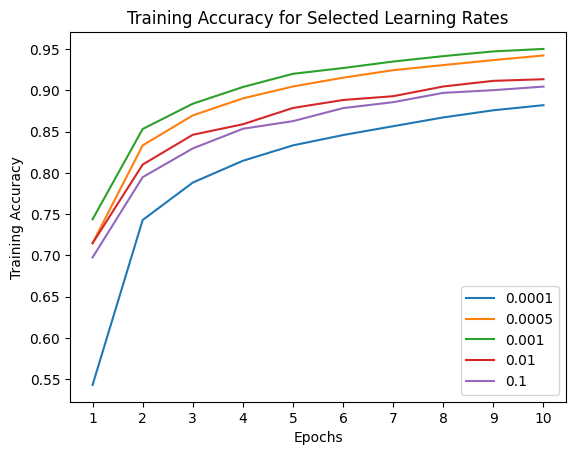

In [56]:
#Plotting the train accuracy
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=lr)

plt.title('Training Accuracy for Selected Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')

plt.xticks(np.arange(10), np.arange(1,11))
plt.legend()

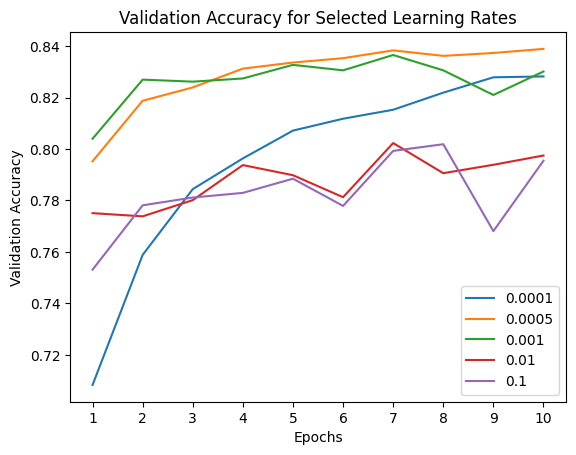

In [57]:
#Plotting the validation accuracy
for lr, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=lr)

    
plt.title('Validation Accuracy for Selected Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

plt.xticks(np.arange(10), np.arange(1,11))
plt.legend()

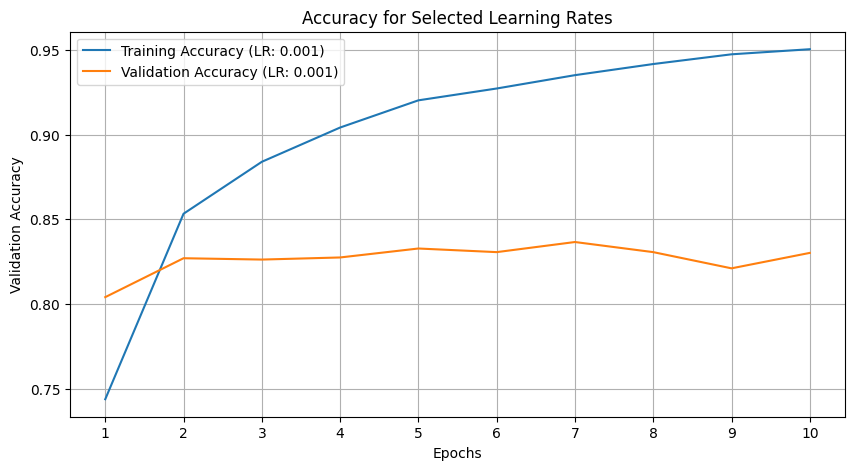

In [58]:
#Plotting validation and train accuracy only for learning rate 0.001
lr=0.001
hist = scores[lr]
plt.figure(figsize=(10, 5))
plt.plot(hist['accuracy'], label=f'Training Accuracy (LR: {lr})')
plt.plot(hist['val_accuracy'], label=f'Validation Accuracy (LR: {lr})')

plt.title('Accuracy for Selected Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

plt.xticks(np.arange(len(hist['val_accuracy'])), np.arange(1, len(hist['val_accuracy']) + 1))
plt.legend()
plt.grid()
plt.show()

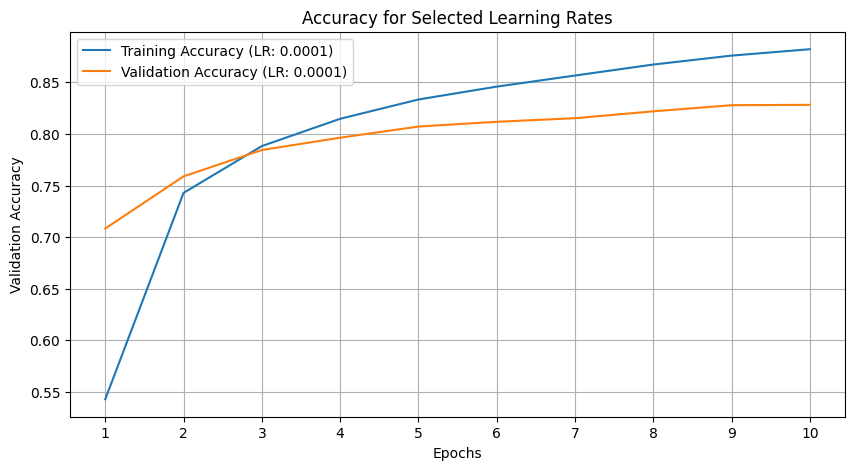

In [59]:
#Plotting validation and train accuracy only for learning rate 0.0001
lr=0.0001
hist = scores[lr]
plt.figure(figsize=(10, 5))
plt.plot(hist['accuracy'], label=f'Training Accuracy (LR: {lr})')
plt.plot(hist['val_accuracy'], label=f'Validation Accuracy (LR: {lr})')

plt.title('Accuracy for Selected Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

plt.xticks(np.arange(len(hist['val_accuracy'])), np.arange(1, len(hist['val_accuracy']) + 1))
plt.legend()
plt.grid()
plt.show()

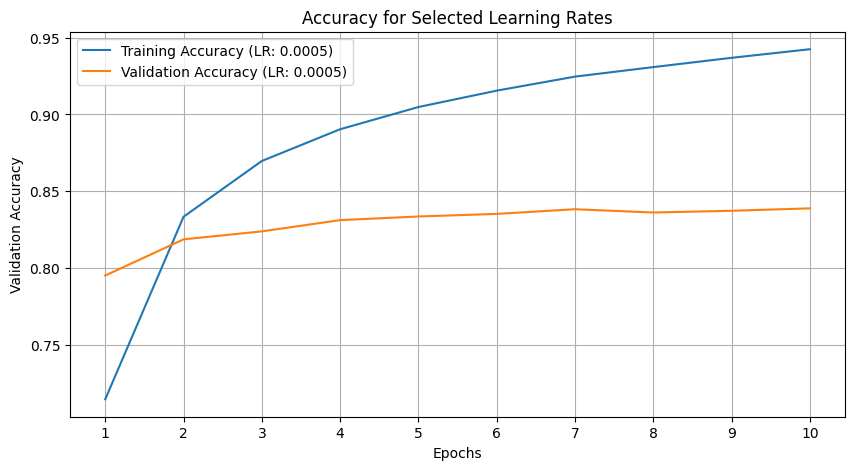

In [60]:
#Plotting validation and train accuracy only for learning rate 0.0005
lr=0.0005
hist = scores[lr]
plt.figure(figsize=(10, 5))
plt.plot(hist['accuracy'], label=f'Training Accuracy (LR: {lr})')
plt.plot(hist['val_accuracy'], label=f'Validation Accuracy (LR: {lr})')

plt.title('Accuracy for Selected Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

plt.xticks(np.arange(len(hist['val_accuracy'])), np.arange(1, len(hist['val_accuracy']) + 1))
plt.legend()
plt.grid()
plt.show()

In [47]:
#Conclusion: The model takes longer to learn with a rate of 0.0001, but the validation and training accuracies are closer together 
#Besides that, does not overfit and after 5 epochs we already have 80% accuracy or better
best_learning_rate=0.0001

In [48]:
MODELS_DIR = '../models'

In [49]:
#Defining function to delete any previously saved files
def delete_previous_checkpoint_files(filename_pattern):
    # Compile the regex pattern
    regex = re.compile(filename_pattern)
    
    # List all files in the specified directory
    files = os.listdir(MODELS_DIR)

    # Filter files matching the regex pattern
    matching_files = [f for f in files if regex.match(f)]
    
    # Check if there are matching files
    if not matching_files:
        print("No matching files found for deletion.")
        return 

    # Iterate through the matching files and delete them
    for checkpoint_file in matching_files:
        full_file_path = os.path.join(MODELS_DIR, checkpoint_file)
        try:
            os.remove(full_file_path)  # Attempt to delete the file
            print(f"Deleted checkpoint file: {checkpoint_file}")
        except Exception as e:
            print(f"Error deleting file {full_file_path}: {e}")

In [50]:
#Define class for a custom checkpoint
class CustomModelCheckpoint(ModelCheckpoint):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.best_accuracy = 0.0
        self.best_model_file = ""

    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)  # Call the parent method
        current_val_accuracy = logs.get('val_accuracy')

        if current_val_accuracy > self.best_accuracy:
            # Update best values
            self.best_accuracy = current_val_accuracy
            self.best_model_file = self.filepath.format(epoch=epoch+1, **logs)
            print(f"New best model saved at epoch {epoch+1} with validation accuracy {self.best_accuracy:.3f}.Filename:{self.best_model_file}")

In [65]:
#deleting any previous files
print('Deleting files previously saved to output directory\n')
delete_previous_checkpoint_files(r'Mobile_v1.*\.keras')
print(f'\nTraining the model with learning rate {best_learning_rate}\n')
#definining a checkpoint to save the model when the accuracy is the max accuracy
custom_checkpoint = CustomModelCheckpoint(f'{MODELS_DIR}/Mobile_v1_{{epoch:02d}}_{{val_accuracy:.3f}}.keras',
                                save_best_only=True,
                                monitor='val_accuracy',
                                mode='max')

model = make_model_Mobile_v1(learning_rate=best_learning_rate)
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks = [custom_checkpoint]
)

Deleting files previously saved to output directory

No matching files found for deletion.

Training the model with learning rate 0.0001

Epoch 1/10
New best model saved at epoch 1 with validation accuracy 0.712.Filename:../models/Mobile_v1_01_0.712.keras727   
833/833 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.3547 - loss: 2.8380 - val_accuracy: 0.7118 - val_loss: 1.0766
Epoch 2/10
New best model saved at epoch 2 with validation accuracy 0.757.Filename:../models/Mobile_v1_02_0.757.keras983 
833/833 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.7278 - loss: 0.9689 - val_accuracy: 0.7574 - val_loss: 0.8220
Epoch 3/10
New best model saved at epoch 3 with validation accuracy 0.783.Filename:../models/Mobile_v1_03_0.783.keras430   
833/833 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.7766 - loss: 0.7410 - val_accuracy: 0.7834 - val_loss: 0.7239
Epoch 4/10
New best model saved at epoch 4 with validation accuracy 0.796.Filename:../models/Mobile_v1_04_0.796.keras278 
833/833 ━━━━━

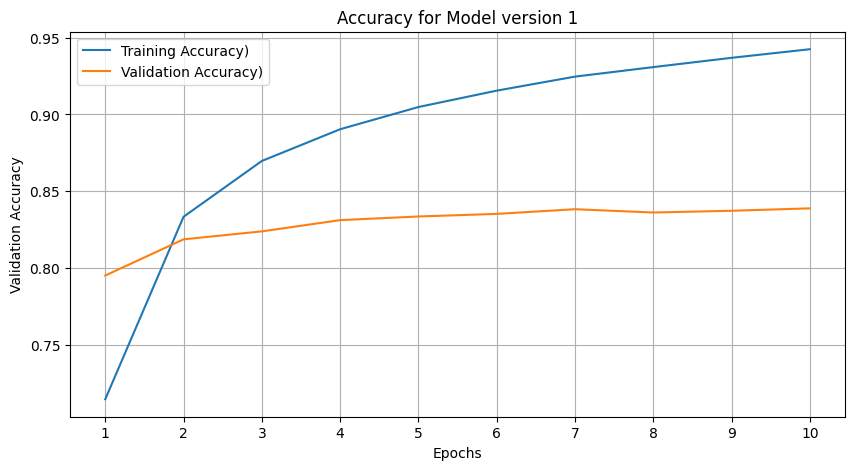

In [66]:
plt.figure(figsize=(10, 5))
plt.plot(hist['accuracy'], label=f'Training Accuracy)')
plt.plot(hist['val_accuracy'], label=f'Validation Accuracy)')

plt.title('Accuracy for Model version 1')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

plt.xticks(np.arange(len(hist['val_accuracy'])), np.arange(1, len(hist['val_accuracy']) + 1))
plt.legend()
plt.grid()
plt.show()

In [67]:
print(f"Best Validation Accuracy for 'Mobile version 1' model: {round(custom_checkpoint.best_accuracy, 4)}")
print(f"Saved Model File: {custom_checkpoint.best_model_file}")

Best Validation Accuracy for 'Mobile version 1' model: 0.828
Saved Model File: ../models/Mobile_v1_10_0.828.keras


In [68]:
#Even when the best accuracy is achieved later in the training, I will select the model at epoch 4, because there is a smaller
#gap between the training accuracy and the validation accuracy and the validation accuracy is not bad, it is over 80%

#build checkpoint file name for epoch 5
epoch=5
epoch_index = epoch-1  #the epochs are 0 indexed
val_accuracy = history.history['val_accuracy'][epoch_index]  
checkpoint_filename = f'Mobile_v1_{epoch:02d}_{val_accuracy:.3f}.keras'

#verify that the file exists
checkpoint_file_path = os.path.join(MODELS_DIR, checkpoint_filename)

# Check if the file exists
if not os.path.isfile(checkpoint_file_path):
    print(f"Checkpoint file does not exist: {checkpoint_file_path}")
    checkpoint_filename='not found'

#store results for model version 1
model_results['mobile_v1'] = {
    'accuracy': round(val_accuracy, 4),
    'filename': checkpoint_filename
}

In [69]:
model_results['mobile_v1']

{'accuracy': 0.8024, 'filename': 'Mobile_v1_05_0.802.keras'}

## Create Model version 2 by adding another inner layer

In [70]:
def make_model_Mobile_v2(learning_rate=0.01, inner_layer_units=1420):
    #clear any unused session
    tf.keras.backend.clear_session()

    #creating a base model
    input_shape = (TARGET_SIZE[0], TARGET_SIZE[1], 3)
    base_model =MobileNetV2(weights='imagenet', input_shape=input_shape, include_top=False)
    # create a model from the base model
    base_model.trainable=False
    inputs = keras.Input(shape=input_shape)
    base = base_model(inputs, training=False)
    
    #pooling layer
    pooling = keras.layers.GlobalAveragePooling2D()
    vectors = pooling(base)

    #dense layer 1
    inner = keras.layers.Dense(inner_layer_units, activation='relu')(vectors)
    
    #dense layer 2
    outputs = keras.layers.Dense(units=count_classes, activation='softmax')(inner)

    #final model
    model = keras.Model(inputs, outputs)

    #compile de model
    optimizer =keras.optimizers.Adam(learning_rate=learning_rate)
    loss=keras.losses.CategoricalCrossentropy(from_logits=False)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

### Find the best inner layer size

In [71]:
print('Deleting files previously saved to output directory\n')
delete_previous_checkpoint_files(r'Mobile_v2_size.*\.keras')
print(f'Training the model with different sizes for the inner layer \n')

scores={}
for size in [count_classes*3, count_classes*5, count_classes*10, count_classes*20]:
    print(f'Fitting model for size {size}')
    custom_checkpoint = CustomModelCheckpoint(f'{MODELS_DIR}/Mobile_v2_size{size}_{{epoch:02d}}_{{val_accuracy:.3f}}.keras',
                                save_best_only=False,
                                monitor='val_accuracy',
                                mode='max')    
    model = make_model_Mobile_v2(learning_rate=best_learning_rate, inner_layer_units=size)
    history = model.fit(train_gen, epochs=10, validation_data=val_gen, callbacks = [custom_checkpoint])
    scores[size] = history.history
    print()
    print()

Deleting files previously saved to output directory

No matching files found for deletion.
Training the model with different sizes for the inner layer 

Fitting model for size 384
Epoch 1/10
New best model saved at epoch 1 with validation accuracy 0.771.Filename:../models/Mobile_v2_size384_01_0.771.keras
833/833 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.5384 - loss: 2.1186 - val_accuracy: 0.7712 - val_loss: 0.8154
Epoch 2/10
New best model saved at epoch 2 with validation accuracy 0.805.Filename:../models/Mobile_v2_size384_02_0.805.keras
833/833 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.7972 - loss: 0.7080 - val_accuracy: 0.8047 - val_loss: 0.6632
Epoch 3/10
New best model saved at epoch 3 with validation accuracy 0.816.Filename:../models/Mobile_v2_size384_03_0.816.keras
833/833 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.8400 - loss: 0.5420 - val_accuracy: 0.8162 - val_loss: 0.6020
Epoch 4/10
New best model saved at epoch 4 with validation accuracy 0.827.Filename:..

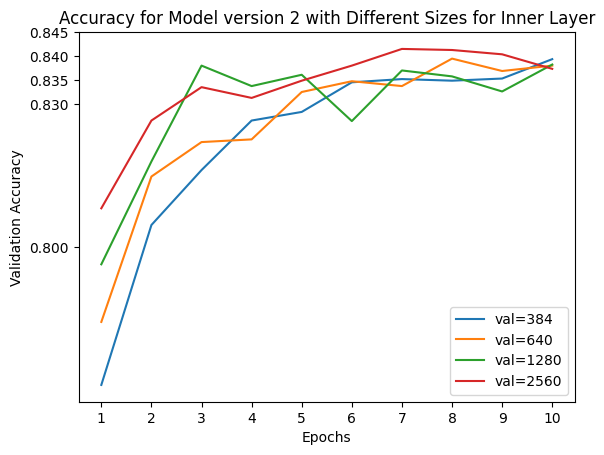

In [72]:
#Plotting the results
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.title('Accuracy for Model version 2 with Different Sizes for Inner Layer')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

plt.xticks(np.arange(10), np.arange(1,11))
plt.yticks([0.80, 0.83, 0.835, 0.84, 0.845])
plt.legend()

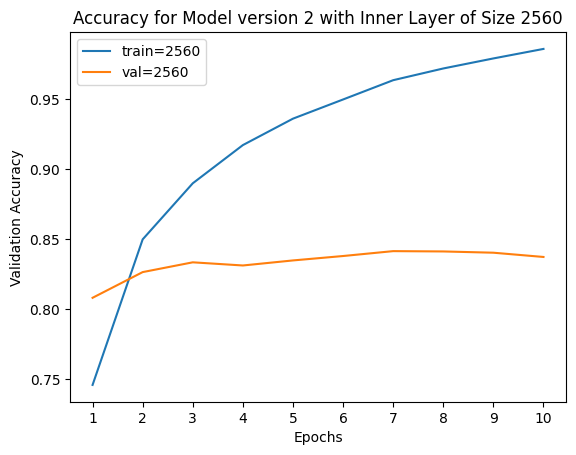

In [73]:
#Plotting training and validation accuracy for model with inner lazyer of size 2560
size = 2560
hist = scores[size]
plt.plot(hist['accuracy'], label=('train=%s' % size))
plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.title('Accuracy for Model version 2 with Inner Layer of Size 2560')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

plt.xticks(np.arange(10), np.arange(1,11))
plt.legend()

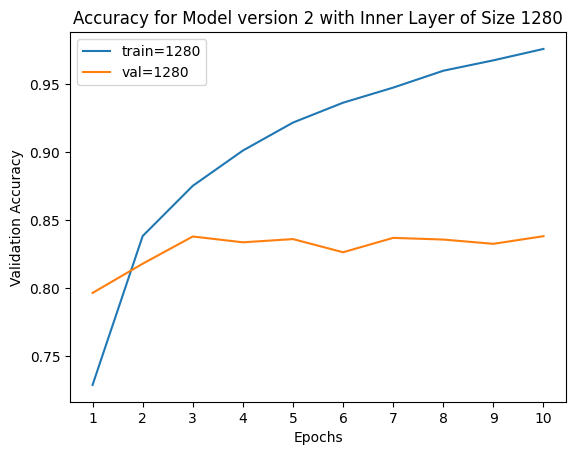

In [74]:
#Plotting training and validation accuracy for model with inner lazyer of size 1280
size = 1280
hist = scores[size]
plt.plot(hist['accuracy'], label=('train=%s' % size))
plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.title('Accuracy for Model version 2 with Inner Layer of Size 1280')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

plt.xticks(np.arange(10), np.arange(1,11))
plt.legend()

In [75]:
##Conclusion, the model overfits, after the second epoch the gap between train accuracy and validation accuracy increases

In [76]:
#Building a resume with the results
best_models_info = {}

for size in scores.keys():
    best_val_accuracy = max(scores[size]['val_accuracy'])
    
    checkpoint_filename_pattern = f'Mobile_v2_size{size}_*_{best_val_accuracy:.3f}.keras'
    checkpoint_files = glob.glob(os.path.join(MODELS_DIR, checkpoint_filename_pattern))
    
    if checkpoint_files:
        best_models_info[size] = {
            'best_accuracy': best_val_accuracy,
            'checkpoint_file': checkpoint_files[0]  # Get the first matching file
        }
    else:
        print(f"No checkpoint files found for size {size} with accuracy {best_val_accuracy:.3f}")

for size, info in best_models_info.items():
    print(f"Best model for inner layer size {size}:")
    print(f"Best Validation Accuracy: {info['best_accuracy']:.3f}")
    print(f"Checkpoint file: {info['checkpoint_file']}")        

Best model for inner layer size 384:
Best Validation Accuracy: 0.839
Checkpoint file: ../models/Mobile_v2_size384_10_0.839.keras
Best model for inner layer size 640:
Best Validation Accuracy: 0.839
Checkpoint file: ../models/Mobile_v2_size640_08_0.839.keras
Best model for inner layer size 1280:
Best Validation Accuracy: 0.838
Checkpoint file: ../models/Mobile_v2_size1280_03_0.838.keras
Best model for inner layer size 2560:
Best Validation Accuracy: 0.841
Checkpoint file: ../models/Mobile_v2_size2560_08_0.841.keras


In [77]:
inner_layer_size_higher_accuracy = 2560
print(f"Best Validation Accuracy for 'Mobile version 2' model: {round(best_models_info[inner_layer_size_higher_accuracy]['best_accuracy'], 4)}")
print(f"Saved Model File: {best_models_info[inner_layer_size_higher_accuracy]['checkpoint_file']}")

Best Validation Accuracy for 'Mobile version 2' model: 0.8415
Saved Model File: ../models/Mobile_v2_size2560_08_0.841.keras


In [78]:
# Conclusion: The inner layer size of 2560 provides the best accuracy, but this occurs at an epoch when the model is already overfitting. 
# Therefore, if I were to keep an inner layer, I would choose a size of 1280 and use the model from the second epoch.
#build checkpoint file name for epoch 2
best_inner_layer_size=1280
epoch=2
epoch_index = epoch-1  #the epochs are 0 indexed
val_accuracy = scores[best_inner_layer_size]['val_accuracy'][epoch_index]  
checkpoint_filename = f'Mobile_v2_size1280_{epoch:02d}_{val_accuracy:.3f}.keras'

#verify that the file exists
checkpoint_file_path = os.path.join(MODELS_DIR, checkpoint_filename)

# Check if the file exists
if not os.path.isfile(checkpoint_file_path):
    print(f"Checkpoint file does not exist: {checkpoint_file_path}")
    checkpoint_filename='not found'

#store results for model version 1
model_results['mobile_v2'] = {
    'accuracy': round(val_accuracy, 4),
    'filename': checkpoint_filename
}

In [79]:
model_results['mobile_v2']

{'accuracy': 0.818, 'filename': 'Mobile_v2_size1280_02_0.818.keras'}

### Creating Mobile Model version 3 by adding regularization to the inner layer

In [55]:
def make_model_Mobile_v3(learning_rate, inner_layer_units, l2_factor):
    #clear any unused session
    tf.keras.backend.clear_session()

    #creating a base model
    input_shape = (TARGET_SIZE[0], TARGET_SIZE[1], 3)
    base_model =MobileNetV2(weights='imagenet', input_shape=input_shape, include_top=False)
    # create a model from the base model
    base_model.trainable=False
    inputs = keras.Input(shape=input_shape)
    base = base_model(inputs, training=False)
    
    #pooling layer
    pooling = keras.layers.GlobalAveragePooling2D()
    vectors = pooling(base)

    #dense layer 1
    inner = keras.layers.Dense(inner_layer_units, activation='relu',
                              kernel_regularizer=keras.regularizers.L2(l2_factor))(vectors)
    
    #dense layer 2
    outputs = keras.layers.Dense(units=count_classes, activation='softmax')(inner)

    #final model
    model = keras.Model(inputs, outputs)

    #compile de model
    optimizer =keras.optimizers.Adam(learning_rate=learning_rate)
    loss=keras.losses.CategoricalCrossentropy(from_logits=False)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

In [65]:
print('Deleting files previously saved to output directory\n')
delete_previous_checkpoint_files(r'Mobile_v3_l2factor.*\.keras')
print(f'Training the model with different l2 factors for the inner layer \n')

learning_rate=0.0001
inner_layer_units= 1280
factors = [0.0001, 0.0003, 0.0005]
scores={}
for factor in factors:
    print(f'Fitting model for l2 factor {factor}')
    custom_checkpoint = CustomModelCheckpoint(f'{MODELS_DIR}/Mobile_v3_l2factor{factor}_{{epoch:02d}}_{{val_accuracy:.3f}}.keras',
                                save_best_only=True,
                                monitor='val_accuracy',
                                mode='max')    
    model = make_model_Mobile_v3(learning_rate=learning_rate, inner_layer_units=inner_layer_units, l2_factor=factor)
    history = model.fit(train_gen, epochs=10, validation_data=val_gen, callbacks = [custom_checkpoint])
    scores[factor] = history.history
    print()
    print()

Deleting files previously saved to output directory

Deleted checkpoint file: Mobile_v3_l2factor0.0001_03_0.804.keras
Deleted checkpoint file: Mobile_v3_l2factor0.0001_07_0.818.keras
Deleted checkpoint file: Mobile_v3_l2factor0.0001_05_0.815.keras
Deleted checkpoint file: Mobile_v3_l2factor0.0001_02_0.800.keras
Deleted checkpoint file: Mobile_v3_l2factor0.0001_10_0.827.keras
Deleted checkpoint file: Mobile_v3_l2factor0.0001_01_0.775.keras
Deleted checkpoint file: Mobile_v3_l2factor0.0001_04_0.807.keras
Deleted checkpoint file: Mobile_v3_l2factor0.0001_08_0.824.keras
Training the model with different l2 factors for the inner layer 

Fitting model for l2 factor 0.0001
Epoch 1/10
New best model saved at epoch 1 with validation accuracy 0.781.Filename:../models/Mobile_v3_l2factor0.0001_01_0.781.keras
833/833 ━━━━━━━━━━━━━━━━━━━━ 40s 39ms/step - accuracy: 0.6206 - loss: 1.7785 - val_accuracy: 0.7813 - val_loss: 0.8913
Epoch 2/10
New best model saved at epoch 2 with validation accuracy 0.798

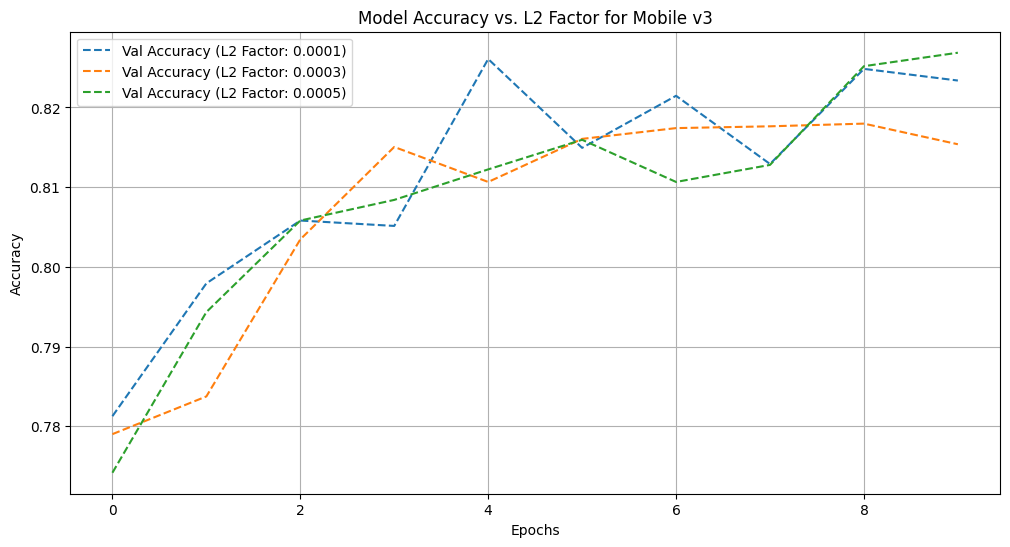

In [70]:
#Plotting the validation accuracy
for lr, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=lr)

    
plt.title('Model Accuracy vs L2 Factor for Mobile v3')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

plt.xticks(np.arange(10), np.arange(1,11))
plt.legend()

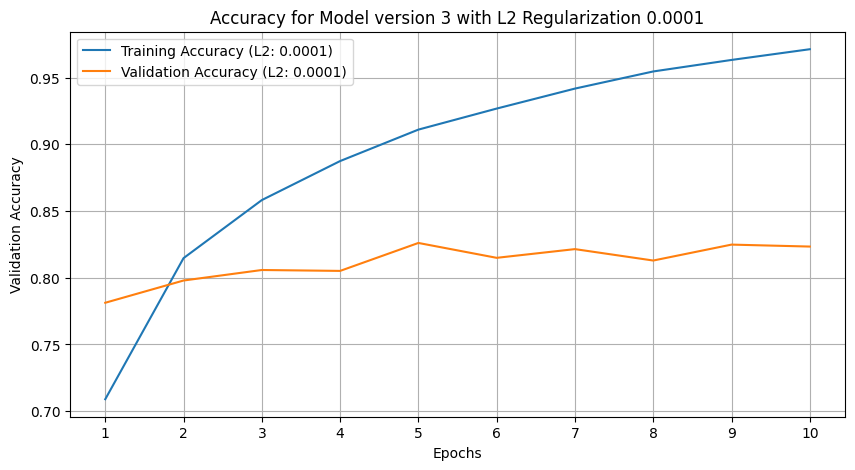

In [71]:
#Plotting training and validation accuracy for l2 factor=0.0001
f=0.0001
hist = scores[f]
plt.figure(figsize=(10, 5))
plt.plot(hist['accuracy'], label=f'Training Accuracy (L2: {f})')
plt.plot(hist['val_accuracy'], label=f'Validation Accuracy (L2: {f})')

plt.title(f'Accuracy for Model version 3 with L2 Regularization {f}')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

plt.xticks(np.arange(len(hist['val_accuracy'])), np.arange(1, len(hist['val_accuracy']) + 1))
plt.legend()
plt.grid()
plt.show()

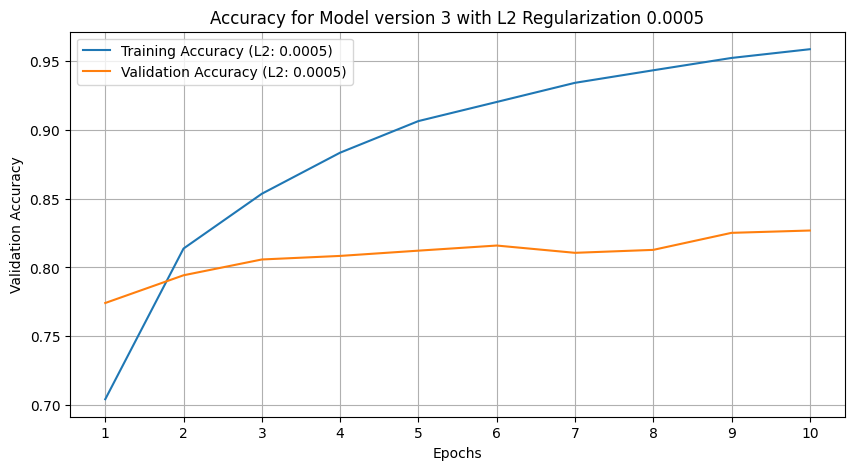

In [72]:
#Plotting training and validation accuracy for l2 factor=0.0005
f=0.0005
hist = scores[f]
plt.figure(figsize=(10, 5))
plt.plot(hist['accuracy'], label=f'Training Accuracy (L2: {f})')
plt.plot(hist['val_accuracy'], label=f'Validation Accuracy (L2: {f})')

plt.title(f'Accuracy for Model version 3 with L2 Regularization {f}')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

plt.xticks(np.arange(len(hist['val_accuracy'])), np.arange(1, len(hist['val_accuracy']) + 1))
plt.legend()
plt.grid()
plt.show()

In [73]:
#I will go with a regularization of 0.0005, because the curve is smoother than the one for 0.0001

### Creating Mobile Model version 4 by adding a dropout layer

In [74]:
def make_model_Mobile_v4(learning_rate, inner_layer_units, l2_factor, droprate):
    
    #clear any unused session
    tf.keras.backend.clear_session()

    #creating a base model
    input_shape = (TARGET_SIZE[0], TARGET_SIZE[1], 3)
    base_model =MobileNetV2(weights='imagenet', input_shape=input_shape, include_top=False)
    # create a model from the base model
    base_model.trainable=False
    inputs = keras.Input(shape=input_shape)
    base = base_model(inputs, training=False)
    
    #pooling layer
    vectors = keras.layers.GlobalAveragePooling2D()(base)

    #dense layer 1
    inner = keras.layers.Dense(inner_layer_units, activation='relu',
                              kernel_regularizer=keras.regularizers.L2(l2_factor))(vectors)

    #dropout for inner layer 1
    drop = keras.layers.Dropout(droprate)(inner)
    
    #dense layer 2
    outputs = keras.layers.Dense(units=count_classes, activation='softmax')(drop)

    #final model
    model = keras.Model(inputs, outputs)

    #compile de model
    optimizer =keras.optimizers.Adam(learning_rate=learning_rate)
    loss=keras.losses.CategoricalCrossentropy(from_logits=False)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

In [78]:
print('Deleting files previously saved to output directory\n')
delete_previous_checkpoint_files(r'Mobile_v4_droprate.*\.keras')
print(f'Training the model with different dropout rates for the inner layer \n')

learning_rate=0.0001
inner_layer_units= 1280
l2_factor=0.0005
droprates = [0.0, 0.1, 0.2, 0.3]
scores={}
#I initially experimented with a variety of dropout rates during the training and 30 epochs
#but the accuracy wasnt higher and it took too long, so I narrowed it down to fewer options in the notebook and fewer epochs
for droprate in droprates:
    print(f'Fitting model for drop rate {droprate}')
    custom_checkpoint = CustomModelCheckpoint(f'{MODELS_DIR}/Mobile_v4_droprate{droprate}_{{epoch:02d}}_{{val_accuracy:.3f}}.keras',
                                save_best_only=True,
                                monitor='val_accuracy',
                                mode='max')    
    model = make_model_Mobile_v4(learning_rate=learning_rate, inner_layer_units=inner_layer_units, l2_factor=l2_factor, droprate=droprate)
    history = model.fit(train_gen, epochs=10, validation_data=val_gen, callbacks = [custom_checkpoint])
    scores[droprate] = history.history
    print()
    print()

Deleting files previously saved to output directory

No matching files found for deletion.
Training the model with different dropout rates for the inner layer 

Fitting model for drop rate 0.0
Epoch 1/10
New best model saved at epoch 1 with validation accuracy 0.772.Filename:../models/Mobile_v4_droprate0.0_01_0.772.keras
833/833 ━━━━━━━━━━━━━━━━━━━━ 51s 52ms/step - accuracy: 0.6076 - loss: 2.3308 - val_accuracy: 0.7723 - val_loss: 1.3839
Epoch 2/10
New best model saved at epoch 2 with validation accuracy 0.807.Filename:../models/Mobile_v4_droprate0.0_02_0.807.keras
833/833 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - accuracy: 0.8172 - loss: 1.2180 - val_accuracy: 0.8069 - val_loss: 1.2313
Epoch 3/10
New best model saved at epoch 3 with validation accuracy 0.810.Filename:../models/Mobile_v4_droprate0.0_03_0.810.keras
833/833 ━━━━━━━━━━━━━━━━━━━━ 33s 39ms/step - accuracy: 0.8616 - loss: 1.0179 - val_accuracy: 0.8095 - val_loss: 1.1677
Epoch 4/10
833/833 ━━━━━━━━━━━━━━━━━━━━ 30s 36ms/step - accu

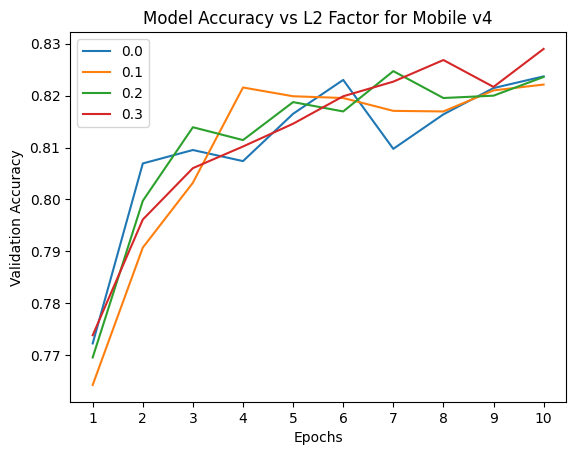

In [81]:
#Plotting the validation accuracy
for dr, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=dr)

    
plt.title('Model Accuracy vs L2 Factor for Mobile v4')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

plt.xticks(np.arange(10), np.arange(1,11))
plt.legend()

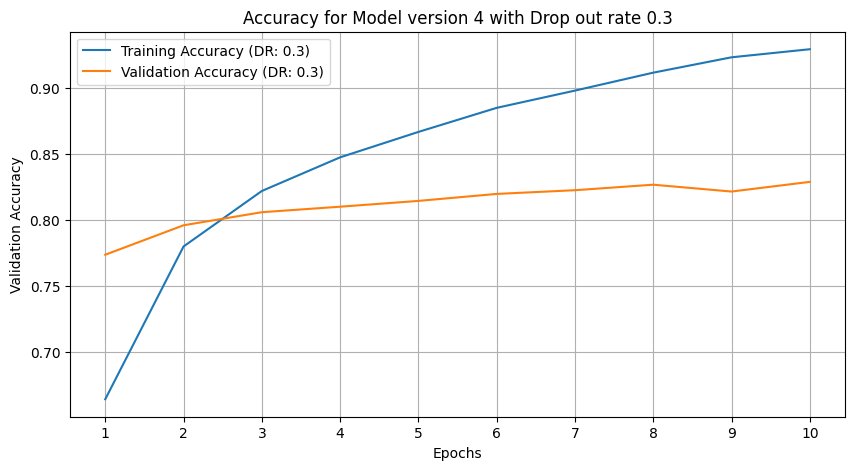

In [86]:
#Plotting training and validation accuracy for dropoutrate=0.3
dr=0.3
hist = scores[dr]
plt.figure(figsize=(10, 5))
plt.plot(hist['accuracy'], label=f'Training Accuracy (DR: {dr})')
plt.plot(hist['val_accuracy'], label=f'Validation Accuracy (DR: {dr})')

plt.title(f'Accuracy for Model version 4 with Drop out rate {dr}')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

plt.xticks(np.arange(len(hist['val_accuracy'])), np.arange(1, len(hist['val_accuracy']) + 1))
plt.legend()
plt.grid()
plt.show()

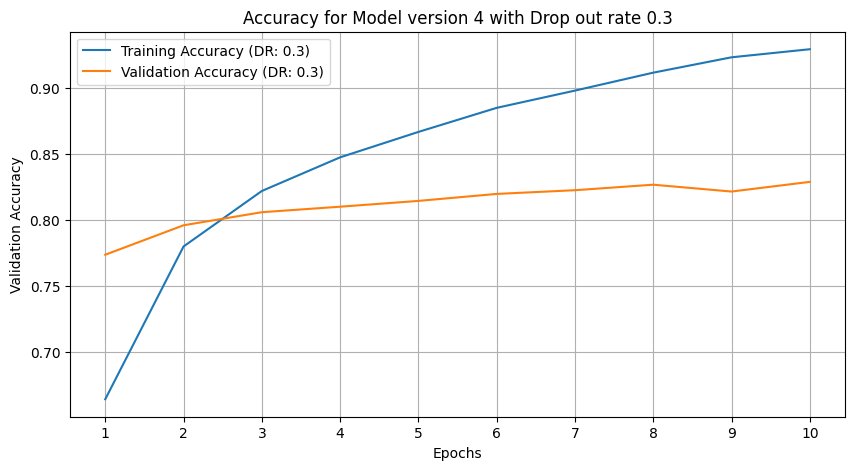

In [87]:
#Plotting training and validation accuracy for dropoutrate=0.2
dr=0.2
hist = scores[dr]
plt.figure(figsize=(10, 5))
plt.plot(hist['accuracy'], label=f'Training Accuracy (DR: {dr})')
plt.plot(hist['val_accuracy'], label=f'Validation Accuracy (DR: {dr})')

plt.title(f'Accuracy for Model version 4 with Drop out rate {dr}')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

plt.xticks(np.arange(len(hist['val_accuracy'])), np.arange(1, len(hist['val_accuracy']) + 1))
plt.legend()
plt.grid()
plt.show()

In [88]:
#Building a summary with the results
best_models_info = {}

for droprate in scores.keys():
    best_val_accuracy = max(scores[droprate]['val_accuracy'])
    
    checkpoint_filename_pattern = f'Mobile_v4_droprate{droprate}_*_{best_val_accuracy:.3f}.keras'
    checkpoint_files = glob.glob(os.path.join(MODELS_DIR, checkpoint_filename_pattern))
    
    if checkpoint_files:
        best_models_info[droprate] = {
            'best_accuracy': best_val_accuracy,
            'checkpoint_file': checkpoint_files[0]  
        }
    else:
        print(f"No checkpoint files found for drop rate {droprate} with accuracy {best_val_accuracy:.3f}")

for droprate, info in best_models_info.items():
    print(f"Best model for drop rate {droprate}:")
    print(f"Best Validation Accuracy: {info['best_accuracy']:.3f}")
    print(f"Checkpoint file: {info['checkpoint_file']}")   

Best model for drop rate 0.0:
Best Validation Accuracy: 0.824
Checkpoint file: ../models/Mobile_v4_droprate0.0_10_0.824.keras
Best model for drop rate 0.1:
Best Validation Accuracy: 0.822
Checkpoint file: ../models/Mobile_v4_droprate0.1_04_0.822.keras
Best model for drop rate 0.2:
Best Validation Accuracy: 0.825
Checkpoint file: ../models/Mobile_v4_droprate0.2_07_0.825.keras
Best model for drop rate 0.3:
Best Validation Accuracy: 0.829
Checkpoint file: ../models/Mobile_v4_droprate0.3_10_0.829.keras


In [97]:
#I will go with droprate 0.2, because the model learns faster
best_droprate=0.2
print(f"Best Validation Accuracy for 'Mobile version 4' model: {round(best_models_info[best_droprate]['best_accuracy'], 4)}")
print(f"Saved Model File: {best_models_info[best_droprate]['checkpoint_file']}")


Best Validation Accuracy for 'Mobile version 3' model: 0.8247
Saved Model File: ../models/Mobile_v4_droprate0.2_07_0.825.keras


In [98]:
#store results for model version 3
model_results['mobile_v4'] = {
    'accuracy': round(best_models_info[best_droprate]['best_accuracy'], 4),
    'filename': best_models_info[best_droprate]['checkpoint_file']
}

In [99]:
model_results['mobile_v4']

{'accuracy': 0.8247,
 'filename': '../models/Mobile_v4_droprate0.2_07_0.825.keras'}

### Training the model Mobile version 4 with augmentation

In [100]:
#declare a new generator for the train dataset
#the generator for the validation dataset is kept as before, the augmentations are applied to the training dataset only
#(the parameters set here were selected after some experimentation)
train_gen = train_image_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGES_DIR, 
    x_col='filename',  
    y_col='articleType', 
    target_size=TARGET_SIZE, 
    batch_size=BATCH_SIZE,
    class_mode='categorical',  
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,                
    workers = workers,
    use_multiprocessing=use_multiprocessing,
    max_queue_size=MAX_QUEUE_SIZE
)

Found 26649 validated image filenames belonging to 128 classes.


In [101]:
#check size of images and batches
batch_images, batch_labels = next(train_gen)  
print("Batch shape for training:", batch_images.shape) 
print("Shape of training labels:", batch_labels.shape) 

batch_images, batch_labels = next(val_gen)  
print("Batch shape for validation:", batch_images.shape) 
print("Shape of validation labels:", batch_labels.shape) 

Batch shape for training: (32, 112, 112, 3)
Shape of training labels: (32, 128)
Batch shape for validation: (32, 112, 112, 3)
Shape of validation labels: (32, 128)


In [102]:
#deleting any previous files
print('Deleting files previously saved to output directory\n')
delete_previous_checkpoint_files(r'Mobile_v4_aug.*\.keras')
print(f'\nTraining the model v4 with augmentation\n')
#definining a checkpoint to save the model when the accuracy is the max accuracy
custom_checkpoint = CustomModelCheckpoint(f'{MODELS_DIR}/Mobile_v4_aug_{{epoch:02d}}_{{val_accuracy:.3f}}.keras',
                                save_best_only=True,
                                monitor='val_accuracy',
                                mode='max')

learning_rate=0.0001
inner_layer_units= 1280
l2_factor=0.0005
droprates = 0.2
model = model = make_model_Mobile_v4(learning_rate=learning_rate, inner_layer_units=inner_layer_units, l2_factor=l2_factor, droprate=droprate)
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks = [custom_checkpoint]
)


Deleting files previously saved to output directory

Deleted checkpoint file: Mobile_v4_aug_08_0.824.keras
Deleted checkpoint file: Mobile_v4_aug_05_0.821.keras
Deleted checkpoint file: Mobile_v4_aug_01_0.771.keras
Deleted checkpoint file: Mobile_v4_aug_03_0.807.keras
Deleted checkpoint file: Mobile_v4_aug_10_0.825.keras
Deleted checkpoint file: Mobile_v4_aug_04_0.810.keras
Deleted checkpoint file: Mobile_v4_aug_02_0.796.keras

Training the model v4 with augmentation

Epoch 1/10
New best model saved at epoch 1 with validation accuracy 0.763.Filename:../models/Mobile_v4_aug_01_0.763.keras  
833/833 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.5644 - loss: 2.5745 - val_accuracy: 0.7635 - val_loss: 1.4505
Epoch 2/10
New best model saved at epoch 2 with validation accuracy 0.795.Filename:../models/Mobile_v4_aug_02_0.795.keras  
833/833 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.7790 - loss: 1.3658 - val_accuracy: 0.7947 - val_loss: 1.2688
Epoch 3/10
New best model saved at epoch 

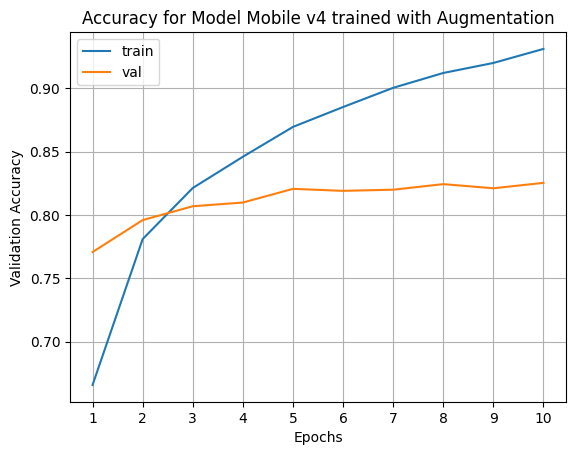

In [96]:
#Plotting train and validation accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')

plt.title('Accuracy for Model Mobile v4 trained with Augmentation')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

num_epochs = len(history.history['val_accuracy'])  
plt.xticks(np.arange(num_epochs), np.arange(1, num_epochs + 1)) 
plt.legend()
plt.grid()
plt.show()

In [96]:
##Conclusion, the model does not overfit and have an accuracy over 82% for the validation dataset, 
# but it is not better than the model trained without augmentation

In [104]:
model_results['mobile_v4_with_augmentation'] = {
    'accuracy': round(custom_checkpoint.best_accuracy, 4),
    'filename': custom_checkpoint.best_model_file
}
print(f"Best Validation Accuracy for 'Mobile version 4 with Augmentation' model: {model_results['mobile_v4_with_augmentation']['accuracy']}")
print(f"Saved Model File: {model_results['mobile_v4_with_augmentation']['filename']}")

Best Validation Accuracy for 'Mobile version 4 with Augmentation' model: 0.8313
Saved Model File: ../models/Mobile_v4_aug_10_0.831.keras


In [105]:
# Display all results
print("Model Evaluation Results:\n")
for model_name, results in model_results.items():
    print(f"Model: {model_name}")
    print(f"  Best Validation Accuracy: {results['accuracy']}")
    print(f"  Checkpoint File: {results['filename']}")
    print()  # Print a newline for better readability

Model Evaluation Results:

Model: mobile_v3
  Best Validation Accuracy: 0.829
  Checkpoint File: ../models/Mobile_v4_droprate0.3_10_0.829.keras

Model: mobile_v4
  Best Validation Accuracy: 0.8247
  Checkpoint File: ../models/Mobile_v4_droprate0.2_07_0.825.keras

Model: mobile_v4_with_augmentation
  Best Validation Accuracy: 0.8313
  Checkpoint File: ../models/Mobile_v4_aug_10_0.831.keras



In [106]:
#Conclusion: I will go with the version 4 of the model, trained without augmentation for 10 epochs
best_model_name='mobile_v4_with_augmentation'

In [100]:
# Calculate time it took to run the notebook
end_time = time.time()
total_time_seconds = end_time - start_time
total_time_minutes = round(total_time_seconds / 60)

print(f"Total execution time for this notebook: {total_time_minutes} minutes")

Total execution time for this notebook: 71 minutes
